## Nonlinear HIFU field in a homogeneous medium - 1st and 2nd harmonics
This demo shows you how to:
* set up a focused HIFU field
* compute the 2nd harmonic generated by the focused field, however only along focal axis
* produce a pretty plot
* compare on-axis field to that generated by *HITU Simulator*.

This code exploits the rotational symmetry of the transducer to rapidly compute the second harmonic along the focal axis. However, this symmetry is only easily exploited if we only wish to compute the second harmonic alone the central (focal) axis. This allows us to perform a 2D, rather than 3D, integral, which can be done very quickly.

If we denote the first harmonic as $p_1$, then the second harmonic in a homogeneous medium is given by the volume integral
$$
    p_2(\mathbf{r}) = -\frac{2\beta\omega^2}{\rho c^4}\int_D \frac{e^{ik_2|\mathbf{r}-\mathbf{s}|}}{4\pi|\mathbf{r}-\mathbf{s}|}p_1^2(\mathbf{s})\text{d}\mathbf{s},\ \mathbf{r}\in D,
$$
where $k_2$ is the wavenumber of the second harmonic and the domain $D$ is chosen to span the width of the transducer's bowl-shaped face and extend to beyond the focus.

The bowl-shaped transducer we consider is rotationally symmetric. Suppose that, rather than wishing to compute $p_2$ at any $\mathbf{r}$ in $D$, we fix $\mathbf{r}$ to lie on the axis of rotational symmetry of the bowl. In this case, our volume integral simplifies to
$$
    p_2(\mathbf{r}_{\text{axis}}) = -\pi\times\frac{2\beta\omega^2}{\rho c^4}\int_D \frac{e^{ik_2|\mathbf{r}_{\text{axis}}-\mathbf{s}|}}{4\pi|\mathbf{r}_{\text{axis}}-\mathbf{s}|}p_1^2(\mathbf{s})y\text{d}y\text{d}x,
$$
where $\mathbf{s}=(x,y)$. Note the additional $\pi$ out the front and the $y$ appearing in the integrand, from the Jacobian of the cylindrical coordinate transformation.

Although we are limited to this central axis, this is still a handy fast calculation to perform - to get a feel for the amount of nonlinearity generated by your transducer setup within the medium of interest.

In [1]:
import os
import sys
# FIXME: figure out how to avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from vines.geometry.geometry import shape
from vines.fields.plane_wave import PlaneWave
from vines.operators.acoustic_operators import volume_potential, volume_potential_cylindrical
from vines.precondition.threeD import circulant_embed_fftw
from vines.operators.acoustic_matvecs import mvp_volume_potential, mvp_vec_fftw
from scipy.sparse.linalg import LinearOperator, gmres
from matplotlib import pyplot as plt
from vines.geometry.geometry import generatedomain2d, generatedomain
from vines.fields.transducers import bowl_transducer, normalise_power
import time
import matplotlib
from matplotlib import pyplot as plt
import itertools

In [ ]:
'''       Define transducer parameters      '''
transducername = 'H131'
f1 = 1.1e6              # operating/fundamental frequency
roc = 0.035             # radius of curvature / focal length (roc)
inner_D = 0.0           # inner diameter (inner_D)
outer_D = 0.033         # outer diameter (outer_D)
power = 100             # total acoustic power (power)
focus = [roc, 0., 0.]   # focus location

In [17]:
'''     Define medium parameters     '''
material = 'water'
c = 1480.0      # speed of sound
rho = 1000.0     # medium density
(alpha0, eta) = (0.2, 2) # the attenuation power law info
beta = 3.5e0    # nonlinearity parameter

In [4]:
def attenuation(f, alpha0, eta):
    'Attenuation function'
    alpha = alpha0 * (f * 1e-6)**eta
    alpha = alpha / 8.686
    return alpha

In [5]:
# Compute useful quantities: wavelength (lam), wavenumber (k0),
# angular frequency (omega)
lam = c / f1
k1 = 2 * np.pi * f1 / c + 1j * attenuation(f1, alpha0, eta)
omega = 2 * np.pi * f1

In [18]:
# Define the resolution of the voxel mesh - number of voxels per wavelength
nPerLam = 5

In [20]:
# Create voxel mesh
dx = lam / nPerLam  # voxel dimension (width=height=depth)

# Dimension of computation domain
# x_start needs to be close to the transducer
# x_end can be just beyond the focus
# the width in the y,z directions should be around the width of outer_D,
# but you can shrink this to speed up computations if required
# x_start = roc - 0.99 * np.sqrt(roc**2 - (outer_D/2)**2)
x_start = 0
x_end = roc + 0.01
wx = x_end - x_start
wy = outer_D*1
wz = wy/1000  # we only want the mesh to be one voxel deep, i.e., an (x,y)-planar mesh

start = time.time()
# r, L, M = generatedomain2d(dx, wx, wy)
r, L, M, N = generatedomain(dx, wx, wy, wz)

# Adjust r by shifting x locations
r[:, :, :, 0] = r[:, :, :, 0] - r[0, 0, 0, 0] + x_start
# r[:, :, :, 1] = r[:, :, :, 1] - r[0, 0, 0, 1]
end = time.time()
print('Mesh generation time:', end-start)
points = r.reshape(L*M*N, 3, order='F')
print('Number of voxels = ', L*M*N)

Mesh generation time: 0.006500959396362305
Number of voxels =  20541


In [21]:
# Compute the first harmonic generated by the bowl-shaped transducer
start = time.time()
n_elements = 2**12
x, y, z, p = bowl_transducer(k1, roc, focus, outer_D / 2, n_elements,
                             inner_D / 2, points.T, 'x')
end = time.time()
print('Incident field evaluation time (s):', end-start)
dist_from_focus = np.sqrt((points[:, 0]-focus[0])**2 + points[:, 1]**2 +
                           points[:,2]**2)
idx_near = np.abs(dist_from_focus - roc) < 5e-4
p[idx_near] = 0.0

# Normalise incident field to achieve desired total acoutic power
p0 = normalise_power(power, rho, c, outer_D/2, k1, roc,
                     focus, n_elements, inner_D/2)

p *= p0

P = np.zeros((2, L, M, N), dtype=np.complex128)
P[0] = p.reshape(L, M, N, order='F')

Incident field evaluation time (s): 1.6036138534545898


Text(0, 0.5, 'Pressure (MPa)')

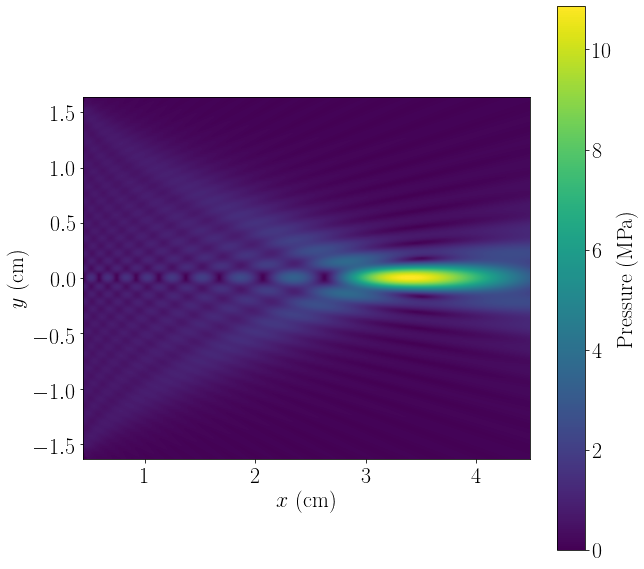

In [10]:
# Create a pretty plot of the first harmonic in the domain
matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
xmin, xmax = r[0, 0, 0, 0] * 100, r[-1, 0, 0, 0] * 100
ymin, ymax = r[0, 0, 0, 1] * 100, r[0, -1, 0, 1] * 100
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(np.abs(P[0, :, :, np.int(np.floor(N/2))].T / 1e6),
           extent=[xmin, xmax, ymin, ymax],
           cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')
plt.xlabel(r'$x$ (cm)')
plt.ylabel(r'$y$ (cm)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pressure (MPa)')

In [11]:
# Compute second harmonic
f2 = 2 * f1
k2 = 2 * np.pi * f2 / c + 1j * attenuation(f2, alpha0, eta)

# Assemble volume potential Toeplitz operator perform circulant embedding
start = time.time()
# toep_op = volume_potential_cylindrical(k2, r)
toep_op = volume_potential(k2, r)

circ_op = circulant_embed_fftw(toep_op, L, M, N)
end = time.time()
print('Operator assembly and its circulant embedding:', end-start)

# Create vector for matrix-vector product
xIn = -2 * beta * omega**2 / (rho * c**4) * P[0] * P[0] * np.abs(r[:, :, :, 1]) #* 2 * np.pi

Operator assembly and its circulant embedding: 1.9911401271820068


In [12]:
def mvp(x):
    'Matrix-vector product operator'
    return mvp_volume_potential(x, circ_op, idx, Mr)

In [13]:
xInVec = xIn.reshape((L*M*N, 1), order='F')
idx = np.ones((L, M, N), dtype=bool)

In [14]:
# Voxel permittivities
Mr = np.ones((L, M, N), dtype=np.complex128)

# Perform matrix-vector product
start = time.time()
P[1] = mvp(xInVec).reshape(L, M, N, order='F')
end = time.time()
print('MVP time = ', end - start)


# Now evaluate the volume potential for points along central axis
dA = dx**2  # element of area
# Central axis line
x_line = r[:, 0, 0, 0]  # - np.array([0, dx/2, 0])

p2_line = (P[1, :, 0, 0])

MVP time =  0.5446159839630127


Text(0, 0.5, 'Pressure (MPa)')

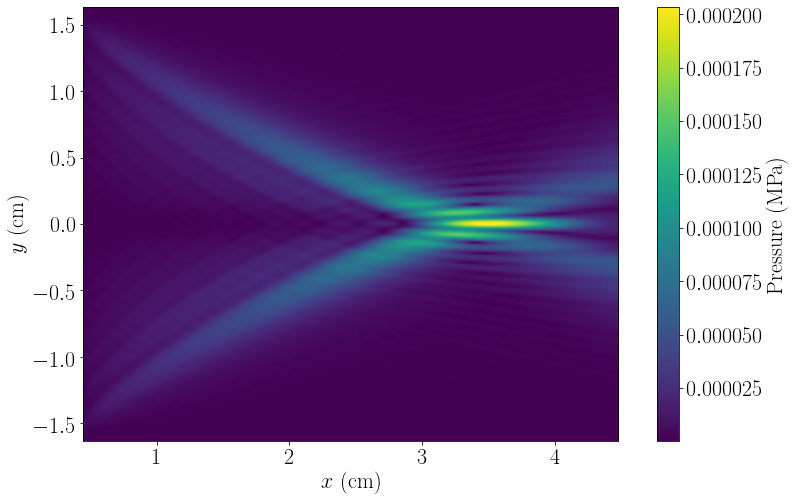

In [15]:
matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
xmin, xmax = r[0, 0, 0, 0] * 100, r[-1, 0, 0, 0] * 100
ymin, ymax = r[0, 0, 0, 1] * 100, r[0, -1, 0, 1] * 100
fig = plt.figure(figsize=(14, 8))
ax = fig.gca()
plt.imshow(np.abs(P[1, :, :, np.int(np.floor(N/2))].T / 1e6),
           extent=[xmin, xmax, ymin, ymax],
           cmap=plt.cm.get_cmap('viridis'), interpolation='spline16')
plt.xlabel(r'$x$ (cm)')
plt.ylabel(r'$y$ (cm)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pressure (MPa)')

Text(0, 0.5, 'Pressure (MPa)')

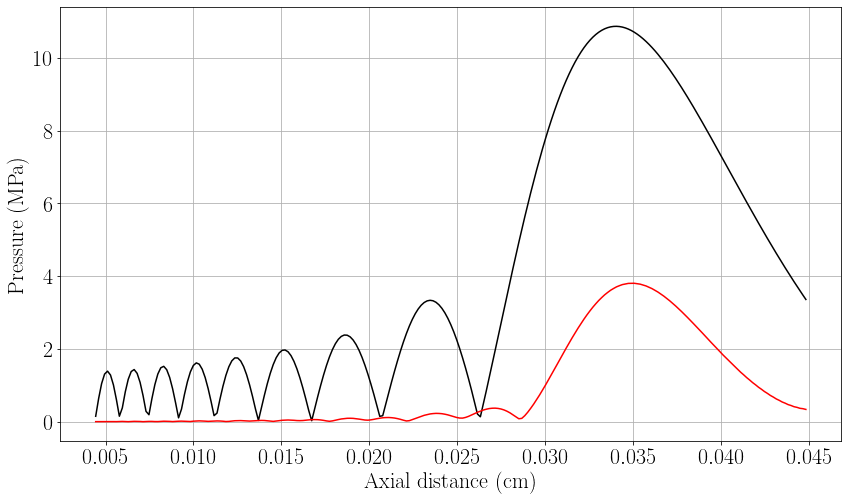

In [16]:
ny_centre = np.int(np.floor(M/2))
nz_centre = np.int(np.floor(N/2))
fig = plt.figure(figsize=(14, 8))
# from IPython import embed; embed()
ax = fig.gca()
plt.plot(x_line, np.abs(P[0, :, ny_centre, nz_centre])/1e6, 'k-')
plt.plot(x_line, np.abs(P[1, :, ny_centre, nz_centre])/(dx*1e6)*np.pi, 'r-')
plt.grid(True)
# plt.xlim([x_start*100, x_end*100])
# plt.ylim([0, 8])
plt.xlabel(r'Axial distance (cm)')
plt.ylabel(r'Pressure (MPa)')